<a href="https://colab.research.google.com/github/thunderhoser/cira_uq4ml/blob/main/quantile_regression_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and define constants

In [55]:
import math
import numpy
from matplotlib import pyplot
from scipy.stats import norm
from scipy.integrate import simps
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, \
    Concatenate, Activation, Add
from tensorflow import keras as tf_keras
from keras.datasets import mnist

NUM_GRID_ROWS = 28
NUM_GRID_COLUMNS = 28

QUANTILE_LEVELS = numpy.linspace(0.01, 0.99, num=99)
QUANTILE_LEVELS = numpy.concatenate((
    QUANTILE_LEVELS, numpy.array([0.025, 0.975])
))
QUANTILE_LEVELS = numpy.sort(QUANTILE_LEVELS)

MEAN_PREDICTION_STDEVS_KEY = 'mean_prediction_stdevs'
BIN_EDGE_PREDICTION_STDEVS_KEY = 'bin_edge_prediction_stdevs'
RMSE_VALUES_KEY = 'rmse_values'
EXAMPLE_COUNTS_KEY = 'example_counts'
SPREAD_SKILL_RELIABILITY_KEY = 'spread_skill_reliability'
MEAN_CENTRAL_PREDICTIONS_KEY = 'mean_central_predictions'
MEAN_TARGET_VALUES_KEY = 'mean_target_values'

DISCARD_FRACTIONS_KEY = 'discard_fractions'
ERROR_VALUES_KEY = 'error_values'
EXAMPLE_FRACTIONS_KEY = 'example_fractions'
MONOTONICITY_FRACTION_KEY = 'monotonicity_fraction'

HISTOGRAM_FACE_COLOUR = numpy.full(3, 152. / 255)
HISTOGRAM_EDGE_COLOUR = numpy.full(3, 0.)
HISTOGRAM_EDGE_WIDTH = 2.

MEAN_PREDICTION_LINE_COLOUR = numpy.array([117, 112, 179], dtype=float) / 255
MEAN_PREDICTION_COLOUR_STRING = 'purple'
MEAN_TARGET_LINE_COLOUR = numpy.array([27, 158, 119], dtype=float) / 255
MEAN_TARGET_COLOUR_STRING = 'green'

REFERENCE_LINE_COLOUR = numpy.full(3, 152. / 255)
REFERENCE_LINE_WIDTH = 2.

SPREAD_SKILL_COLOUR = numpy.array([217, 95, 2], dtype=float) / 255
SPREAD_SKILL_LINE_WIDTH = 3.
SPREAD_SKILL_MARKER_TYPE = 'o'
SPREAD_SKILL_MARKER_SIZE = 12

DISCARD_TEST_COLOUR = numpy.array([217, 95, 2], dtype=float) / 255
DISCARD_TEST_LINE_WIDTH = 3.
DISCARD_TEST_MARKER_TYPE = 'o'
DISCARD_TEST_MARKER_SIZE = 12

FONT_SIZE = 30
INSET_FONT_SIZE = 16

pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

# Define loss function

The following cell defines the loss function for one quantile level.  I tried combining all quantile levels in the same loss function (*e.g.*, if you wanted your NN to predict the 5th, 25th, 50th, 75th, and 95th percentiles, you could define a single loss function that uses quantile levels 0.05, 0.25, 0.50, 0.75, and 0.95) -- but one quantile per loss function was just as convenient.  When defining the model architecture (as you will see below), you will need one output layer for each quantile level.
<br><br>
The function created by `quantile_loss` implements the following equation, where $\mathcal{L}$ is the total loss; $q$ is the quantile level, a real number in $(0, 1)$; $y$ is the target value, an integer in $\left[ 0, 1 \right]$; and $p$ is the predicted event probability, a real number in $\left[ 0, 1 \right]$.
<br><br>
$\mathcal{L}(q, y, p) = \begin{cases} (1 - q)\lvert p - y \rvert, &p \ge y \\ q\lvert p - y \rvert, &p < y \end{cases}$

In [56]:
def quantile_loss(quantile_level):
    """Quantile loss function.

    :param quantile_level: Quantile level.
    :return: loss: Loss function (defined below).
    """

    def loss(target_tensor, prediction_tensor):
        """Computes quantile loss.

        :param target_tensor: Tensor of target (actual) values.
        :param prediction_tensor: Tensor of predicted values.
        :return: loss: Quantile loss.
        """

        return K.mean(K.maximum(
            quantile_level * (target_tensor - prediction_tensor),
            (quantile_level - 1) * (target_tensor - prediction_tensor)
        ))

    return loss

# Define private methods

If a method's name begins with an underscore, it is private.  Private methods should be called only by other methods, never directly by the user.

In [57]:
def _plot_means_as_inset(
        figure_object, bin_centers, bin_mean_predictions,
        bin_mean_target_values, for_spread_skill_plot):
    """Plots means (mean prediction and target by bin) as inset in another fig.

    B = number of bins

    :param figure_object: Will plot as inset in this figure (instance of
        `matplotlib.figure.Figure`).
    :param bin_centers: length-B numpy array with value at center of each bin.
        These values will be plotted on the x-axis.
    :param bin_mean_predictions: length-B numpy array with mean prediction in
        each bin.  These values will be plotted on the y-axis.
    :param bin_mean_target_values: length-B numpy array with mean target value
        (event frequency) in each bin.  These values will be plotted on the
        y-axis.
    :param for_spread_skill_plot: Boolean flag.
    :return: inset_axes_object: Axes handle for histogram (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    """

    if for_spread_skill_plot:
        inset_axes_object = figure_object.add_axes([0.625, 0.3, 0.25, 0.25])
    else:
        inset_axes_object = figure_object.add_axes([0.625, 0.55, 0.25, 0.25])

    target_handle = inset_axes_object.plot(
        bin_centers, bin_mean_target_values, color=MEAN_TARGET_LINE_COLOUR,
        linestyle='solid', linewidth=2,
        marker='o', markersize=8, markeredgewidth=0,
        markerfacecolor=MEAN_TARGET_LINE_COLOUR,
        markeredgecolor=MEAN_TARGET_LINE_COLOUR
    )[0]

    prediction_handle = inset_axes_object.plot(
        bin_centers, bin_mean_predictions, color=MEAN_PREDICTION_LINE_COLOUR,
        linestyle='dashed', linewidth=2,
        marker='o', markersize=8, markeredgewidth=0,
        markerfacecolor=MEAN_PREDICTION_LINE_COLOUR,
        markeredgecolor=MEAN_PREDICTION_LINE_COLOUR
    )[0]

    y_max = max([
        numpy.nanmax(bin_mean_predictions),
        numpy.nanmax(bin_mean_target_values)
    ])
    inset_axes_object.set_ylim(0, y_max)
    inset_axes_object.set_xlim(left=0.)

    for this_tick_object in inset_axes_object.xaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(INSET_FONT_SIZE)
        this_tick_object.label.set_rotation('vertical')

    for this_tick_object in inset_axes_object.yaxis.get_major_ticks():
        this_tick_object.label.set_fontsize(INSET_FONT_SIZE)

    inset_axes_object.legend(
        [target_handle, prediction_handle],
        ['Mean target', 'Mean prediction'],
        loc='upper center', bbox_to_anchor=(0.5, -0.2),
        fancybox=True, shadow=True, ncol=1, fontsize=INSET_FONT_SIZE
    )

    return inset_axes_object


def _plot_histogram(axes_object, bin_edges, bin_frequencies):
    """Plots histogram on existing axes.

    B = number of bins

    :param axes_object: Will plot histogram on these axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param bin_centers: length-(B + 1) numpy array with values at edges of each
        bin. These values will be plotted on the x-axis.
    :param bin_frequencies: length-B numpy array with fraction of examples in
        each bin. These values will be plotted on the y-axis.
    :return: histogram_axes_object: Axes handle for histogram only (also
        instance of `matplotlib.axes._subplots.AxesSubplot`).
    """

    histogram_axes_object = axes_object.twinx()
    axes_object.set_zorder(histogram_axes_object.get_zorder() + 1)
    axes_object.patch.set_visible(False)

    histogram_axes_object.bar(
        x=bin_edges[:-1], height=bin_frequencies, width=numpy.diff(bin_edges),
        color=HISTOGRAM_FACE_COLOUR, edgecolor=HISTOGRAM_EDGE_COLOUR,
        linewidth=HISTOGRAM_EDGE_WIDTH, align='edge'
    )

    return histogram_axes_object


def _log2(input_array):
    """Computes logarithm in base 2.

    :param input_array: numpy array.
    :return: logarithm_array: numpy array with the same shape as `input_array`.
    """

    return numpy.log2(numpy.maximum(input_array, 1e-6))

# Define helper methods

The first two methods estimate the mean and standard deviation -- using Equations 14 and 15, respectively, of [Wan *et al.* (2014)](https://doi.org/10.1186/1471-2288-14-135) -- from a set of quantile-based estimates.

The next two methods create the spread-skill plot, which you can read about in [Delle Monache *et al.* (2013)](https://doi.org/10.1175/MWR-D-12-00281.1).

The next two methods after that run and plot the discard test, which you can read about in [Barnes and Barnes (2021)](https://arxiv.org/abs/2104.08236) -- their Figures 2d, 4d, 8d, and 10d.

In [58]:
def get_mean_predictions(prediction_matrix, quantile_levels):
    """Estimates mean from quantile-based estimates.

    E = number of examples
    Q = number of quantile levels

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :param quantile_levels: length-Q numpy array of quantile levels.
    :return: mean_predictions: length-E numpy array of mean predictions.
    """

    TOLERANCE = 1e-6

    first_quartile_index = numpy.where(
        numpy.absolute(quantile_levels - 0.25) <= TOLERANCE
    )[0][0]
    median_index = numpy.where(
        numpy.absolute(quantile_levels - 0.5) <= TOLERANCE
    )[0][0]
    third_quartile_index = numpy.where(
        numpy.absolute(quantile_levels - 0.75) <= TOLERANCE
    )[0][0]

    return (1. / 3) * (
        prediction_matrix[:, first_quartile_index] +
        prediction_matrix[:, median_index] +
        prediction_matrix[:, third_quartile_index]
    )


def get_predictive_stdevs(prediction_matrix, quantile_levels,
                          assume_large_sample_size=True):
    """Estimates standard deviation from quantile-based estimates.

    E = number of examples
    Q = number of quantile levels

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :param quantile_levels: length-Q numpy array of quantile levels.
    :param assume_large_sample_size: Boolean flag.  If True, will assume large
        (essentially infinite) sample size.
    :return: predictive_stdevs: length-E numpy array with standard deviation of
        each predictive distribution.
    """

    TOLERANCE = 1e-6

    first_quartile_index = numpy.where(
        numpy.absolute(quantile_levels - 0.25) <= TOLERANCE
    )[0][0]
    third_quartile_index = numpy.where(
        numpy.absolute(quantile_levels - 0.75) <= TOLERANCE
    )[0][0]

    if assume_large_sample_size:
        psuedo_sample_size = 100
    else:
        psuedo_sample_size = int(numpy.round(
            0.25 * (len(quantile_levels) - 1)
        ))

    coeff_numerator = 2 * math.factorial(4 * psuedo_sample_size + 1)
    coeff_denominator = (
        math.factorial(psuedo_sample_size) *
        math.factorial(3 * psuedo_sample_size)
    )

    z_scores = numpy.linspace(-10, 10, num=1001, dtype=float)
    cumulative_densities = norm.cdf(z_scores, loc=0., scale=1.)
    prob_densities = norm.pdf(z_scores, loc=0., scale=1.)
    integrands = (
        z_scores *
        (cumulative_densities ** (3 * psuedo_sample_size)) *
        ((1. - cumulative_densities) ** psuedo_sample_size) *
        prob_densities
    )

    eta_value = (
        (coeff_numerator / coeff_denominator) *
        simps(y=integrands, x=z_scores, even='avg')
    )

    prob_iqr_values = (
        prediction_matrix[:, third_quartile_index]
        -
        prediction_matrix[:, first_quartile_index]
    )

    return prob_iqr_values / eta_value


def get_spread_vs_skill(
        prediction_matrix, target_values, quantile_levels,
        bin_edge_prediction_stdevs):
    """Computes model spread vs. model skill.

    B = number of bins
    E = number of examples
    Q = number of quantile levels

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :param target_values: length-E numpy array of target values, all integers in
        0...1.
    :param quantile_levels: length-Q numpy array of quantile levels.
    :param bin_edge_prediction_stdevs: length-(B - 1) numpy array of bin
        cutoffs.  Each is a standard deviation for the predictive distribution.
        Ultimately, there will be B + 1 edges; this method will use 0 as the
        lowest edge and 1 as the highest edge.
    :return: result_dict: Dictionary with the following keys.
    result_dict['mean_prediction_stdevs']: length-B numpy array, where the [i]th
        entry is the mean standard deviation of predictive distributions in the
        [i]th bin.
    result_dict['bin_edge_prediction_stdevs']: length-(B + 1) numpy array,
        where the [i]th and [i + 1]th entries are the edges for the [i]th bin.
    result_dict['rmse_values']: length-B numpy array, where the [i]th
        entry is the root mean squared error of central (mean or median)
        predictions in the [i]th bin.
    result_dict['spread_skill_reliability']: Spread-skill reliability (SSREL).
    result_dict['example_counts']: length-B numpy array of corresponding example
        counts.
    result_dict['mean_central_predictions']: length-B numpy array, where the
        [i]th entry is the mean central (mean or median) prediction for the
        [i]th bin.
    result_dict['mean_target_values']: length-B numpy array, where the [i]th
        entry is the mean target value for the [i]th bin.
    """

    # Check input args.
    assert numpy.all(bin_edge_prediction_stdevs > 0.)
    assert numpy.all(bin_edge_prediction_stdevs < 1.)
    assert numpy.all(numpy.diff(bin_edge_prediction_stdevs) > 0.)

    bin_edge_prediction_stdevs = numpy.concatenate((
        numpy.array([0.]),
        bin_edge_prediction_stdevs,
        numpy.array([numpy.inf])
    ))

    num_bins = len(bin_edge_prediction_stdevs) - 1
    assert num_bins >= 2

    mean_predictions = get_mean_predictions(
        prediction_matrix=prediction_matrix, quantile_levels=quantile_levels
    )
    predictive_stdevs = get_predictive_stdevs(
        prediction_matrix=prediction_matrix, quantile_levels=quantile_levels
    )
    squared_errors = (mean_predictions - target_values) ** 2

    binned_mean_prediction_stdevs = numpy.full(num_bins, numpy.nan)
    binned_rmse_values = numpy.full(num_bins, numpy.nan)
    binned_example_counts = numpy.full(num_bins, 0, dtype=int)
    binned_mean_predictions = numpy.full(num_bins, numpy.nan)
    binned_mean_target_values = numpy.full(num_bins, numpy.nan)

    for k in range(num_bins):
        these_indices = numpy.where(numpy.logical_and(
            predictive_stdevs >= bin_edge_prediction_stdevs[k],
            predictive_stdevs < bin_edge_prediction_stdevs[k + 1]
        ))[0]

        binned_mean_prediction_stdevs[k] = numpy.mean(
            predictive_stdevs[these_indices]
        )
        binned_rmse_values[k] = numpy.sqrt(numpy.mean(
            squared_errors[these_indices]
        ))
        binned_example_counts[k] = len(these_indices)
        binned_mean_predictions[k] = numpy.mean(
            mean_predictions[these_indices]
        )
        binned_mean_target_values[k] = numpy.mean(
            target_values[these_indices]
        )

    these_diffs = numpy.absolute(
        binned_mean_prediction_stdevs - binned_rmse_values
    )
    these_diffs[numpy.isnan(these_diffs)] = 0.
    spread_skill_reliability = numpy.average(
        these_diffs, weights=binned_example_counts
    )

    return {
        MEAN_PREDICTION_STDEVS_KEY: binned_mean_prediction_stdevs,
        BIN_EDGE_PREDICTION_STDEVS_KEY: bin_edge_prediction_stdevs,
        RMSE_VALUES_KEY: binned_rmse_values,
        SPREAD_SKILL_RELIABILITY_KEY: spread_skill_reliability,
        EXAMPLE_COUNTS_KEY: binned_example_counts,
        MEAN_CENTRAL_PREDICTIONS_KEY: binned_mean_predictions,
        MEAN_TARGET_VALUES_KEY: binned_mean_target_values
    }


def plot_spread_vs_skill(result_dict):
    """Plots spread vs. skill.

    :param result_dict: Dictionary in format returned by `get_spread_vs_skill`.
    :return: figure_object: Figure handle (instance of
        `matplotlib.figure.Figure`).
    :return: axes_object: Axes handle (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    """

    # Check input args.
    mean_prediction_stdevs = result_dict[MEAN_PREDICTION_STDEVS_KEY]
    rmse_values = result_dict[RMSE_VALUES_KEY]

    nan_flags = numpy.logical_or(
        numpy.isnan(mean_prediction_stdevs),
        numpy.isnan(rmse_values)
    )
    assert not numpy.all(nan_flags)

    # Do actual stuff.
    figure_object, axes_object = pyplot.subplots(
        1, 1, figsize=(12, 12)
    )

    max_value_to_plot = max([
        numpy.nanmax(mean_prediction_stdevs),
        numpy.nanmax(rmse_values)
    ])
    perfect_x_coords = numpy.array([0, max_value_to_plot])
    perfect_y_coords = numpy.array([0, max_value_to_plot])
    axes_object.plot(
        perfect_x_coords, perfect_y_coords, color=REFERENCE_LINE_COLOUR,
        linestyle='dashed', linewidth=REFERENCE_LINE_WIDTH
    )

    real_indices = numpy.where(numpy.invert(nan_flags))[0]
    axes_object.plot(
        mean_prediction_stdevs[real_indices],
        rmse_values[real_indices],
        color=SPREAD_SKILL_COLOUR, linestyle='solid',
        linewidth=SPREAD_SKILL_LINE_WIDTH,
        marker=SPREAD_SKILL_MARKER_TYPE, markersize=SPREAD_SKILL_MARKER_SIZE,
        markeredgewidth=0,
        markerfacecolor=SPREAD_SKILL_COLOUR, markeredgecolor=SPREAD_SKILL_COLOUR
    )

    axes_object.set_xlabel('Spread (stdev of predictive distribution)')
    axes_object.set_ylabel('Skill (RMSE of central prediction)')
    axes_object.set_xlim(0, max_value_to_plot)
    axes_object.set_ylim(0, max_value_to_plot)

    bin_frequencies = (
        result_dict[EXAMPLE_COUNTS_KEY].astype(float) /
        numpy.sum(result_dict[EXAMPLE_COUNTS_KEY])
    )

    bin_edges = result_dict[BIN_EDGE_PREDICTION_STDEVS_KEY]

    if numpy.isnan(mean_prediction_stdevs[-1]):
        bin_edges[-1] = bin_edges[-2] + (bin_edges[-2] - bin_edges[-3])
    else:
        bin_edges[-1] = (
            bin_edges[-2] + 2 * (mean_prediction_stdevs[-1] - bin_edges[-2])
        )

    histogram_axes_object = _plot_histogram(
        axes_object=axes_object,
        bin_edges=result_dict[BIN_EDGE_PREDICTION_STDEVS_KEY],
        bin_frequencies=bin_frequencies * 100
    )
    histogram_axes_object.set_ylabel('% examples in each bin')

    inset_axes_object = _plot_means_as_inset(
        figure_object=figure_object, bin_centers=mean_prediction_stdevs,
        bin_mean_predictions=result_dict[MEAN_CENTRAL_PREDICTIONS_KEY],
        bin_mean_target_values=result_dict[MEAN_TARGET_VALUES_KEY],
        for_spread_skill_plot=True
    )

    inset_axes_object.set_xticks(axes_object.get_xticks())
    inset_axes_object.set_xlim(axes_object.get_xlim())

    inset_axes_object.set_title(
        'Mean target and prediction\nin each bin', fontsize=INSET_FONT_SIZE
    )
    inset_axes_object.set_xlabel('Spread', fontsize=INSET_FONT_SIZE)

    return figure_object, axes_object


def run_discard_test(
        prediction_matrix, target_values, quantile_levels, discard_fractions):
    """Runs the discard test.

    F = number of discard fractions
    E = number of examples
    Q = number of quantile levels

    :param prediction_matrix: E-by-Q numpy array of predicted values.
    :param target_values: length-E numpy array of target values, all integers in
        0...1.
    :param quantile_levels: length-Q numpy array of quantile levels.
    :param discard_fractions: length-(F - 1) numpy array of discard fractions,
        ranging from (0, 1).  This method will use 0 as the lowest discard
        fraction.

    :return: result_dict: Dictionary with the following keys.
    result_dict['discard_fractions']: length-F numpy array of discard fractions,
        sorted in increasing order.
    result_dict['error_values']: length-F numpy array of corresponding error
        values.
    result_dict['example_fractions']: length-F numpy array with fraction of
        examples left after each discard.
    result_dict['mean_central_predictions']: length-F numpy array, where the
        [i]th entry is the mean central (mean or median) prediction for the
        [i]th discard fraction.
    result_dict['mean_target_values']: length-F numpy array, where the [i]th
        entry is the mean target value for the [i]th discard fraction.
    result_dict['monotonicity_fraction']: Monotonicity fraction.  This is the
        fraction of times that the error function improves when discard
        fraction is increased.
    """

    assert numpy.all(discard_fractions > 0.)
    assert numpy.all(discard_fractions < 1.)

    discard_fractions = numpy.concatenate((
        numpy.array([0.]),
        discard_fractions
    ))

    num_fractions = len(discard_fractions)
    assert num_fractions >= 2

    mean_predictions = get_mean_predictions(
        prediction_matrix=prediction_matrix, quantile_levels=quantile_levels
    )
    predictive_stdevs = get_predictive_stdevs(
        prediction_matrix=prediction_matrix, quantile_levels=quantile_levels
    )
    cross_entropy_by_example = (
        target_values * _log2(mean_predictions) +
        (1. - target_values) * _log2(1. - mean_predictions)
    )

    discard_fractions = numpy.sort(discard_fractions)
    discard_error_values = numpy.full(num_fractions, numpy.nan)
    discard_example_fractions = numpy.full(num_fractions, numpy.nan)
    discard_mean_predictions = numpy.full(num_fractions, numpy.nan)
    discard_mean_target_values = numpy.full(num_fractions, numpy.nan)
    use_example_flags = numpy.full(mean_predictions.shape, 1, dtype=bool)

    for k in range(num_fractions):
        this_percentile_level = 100 * (1 - discard_fractions[k])
        this_inverted_mask = (
            predictive_stdevs >
            numpy.percentile(predictive_stdevs, this_percentile_level)
        )
        use_example_flags[this_inverted_mask] = False

        discard_example_fractions[k] = numpy.mean(use_example_flags)
        discard_error_values[k] = -numpy.mean(
            cross_entropy_by_example[use_example_flags == True]
        )
        discard_mean_predictions[k] = numpy.mean(
            mean_predictions[use_example_flags == True]
        )
        discard_mean_target_values[k] = numpy.mean(
            target_values[use_example_flags == True]
        )

    monotonicity_fraction = numpy.mean(numpy.diff(discard_error_values) < 0)

    return {
        DISCARD_FRACTIONS_KEY: discard_fractions,
        ERROR_VALUES_KEY: discard_error_values,
        EXAMPLE_FRACTIONS_KEY: discard_example_fractions,
        MEAN_CENTRAL_PREDICTIONS_KEY: discard_mean_predictions,
        MEAN_TARGET_VALUES_KEY: discard_mean_target_values,
        MONOTONICITY_FRACTION_KEY: monotonicity_fraction
    }


def plot_discard_test(result_dict):
    """Plots results of discard test.

    :param result_dict: Dictionary in format returned by `run_discard_test`.
    :return: figure_object: Figure handle (instance of
        `matplotlib.figure.Figure`).
    :return: axes_object: Axes handle (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    """

    discard_fractions = result_dict[DISCARD_FRACTIONS_KEY]
    error_values = result_dict[ERROR_VALUES_KEY]

    figure_object, axes_object = pyplot.subplots(
        1, 1, figsize=(12, 12)
    )
    axes_object.plot(
        discard_fractions, error_values,
        color=DISCARD_TEST_COLOUR, linestyle='solid',
        linewidth=DISCARD_TEST_LINE_WIDTH,
        marker=DISCARD_TEST_MARKER_TYPE, markersize=DISCARD_TEST_MARKER_SIZE,
        markeredgewidth=0,
        markerfacecolor=DISCARD_TEST_COLOUR, markeredgecolor=DISCARD_TEST_COLOUR
    )

    axes_object.set_xlabel('Discard fraction')
    axes_object.set_ylabel('Model performance (cross-entropy)')
    axes_object.set_xlim(left=0.)

    inset_axes_object = _plot_means_as_inset(
        figure_object=figure_object, bin_centers=discard_fractions,
        bin_mean_predictions=result_dict[MEAN_CENTRAL_PREDICTIONS_KEY],
        bin_mean_target_values=result_dict[MEAN_TARGET_VALUES_KEY],
        for_spread_skill_plot=False
    )

    inset_axes_object.set_xticks(axes_object.get_xticks())
    inset_axes_object.set_xlim(axes_object.get_xlim())

    inset_axes_object.set_title(
        'Mean target and prediction\nafter discard', fontsize=INSET_FONT_SIZE
    )
    inset_axes_object.set_xlabel('Discard fraction', fontsize=INSET_FONT_SIZE)

    return figure_object, axes_object

# Simple model architecture

The following cell defines the architecture of the NN that will carry out quantile regression.  The problem domain is MNIST digit classification, except I have turned the problem into binary classification ("is the digit a 9, or not?") instead of multi-class classification ("is the digit a 0, 1, 2, 3, 4, 5, 6, 7, 8, or 9?").
<br><br>
Recall that, when I defined the quantile loss function above, I used $p$ instead of $\hat{y}$ for the predicted value -- *i.e.*, I assumed that the problem is binary classification and not regression.  However, if you replace $p$ with $\hat{y}$ in that equation, you get the quantile loss for regression.  So this framework is more general than just binary classification.  I am focusing on binary classification here because (a) my problem, predicting the occurrence of convection, is also binary; (b) not many people have used quantile regression for binary classification.

In [60]:
# 28 (rows) x 28 (columns) x 1 (channel) is the size of MNIST images.
input_layer_object = Input(shape=(NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1))

# Define the first part of the architecture (same as in the MNIST example that
# comes with the Keras library).
current_layer_object = Conv2D(
    32, kernel_size=(3, 3), activation='relu'
)(input_layer_object)

current_layer_object = Conv2D(
    64, (3, 3), activation='relu'
)(current_layer_object)

current_layer_object = MaxPooling2D(
    pool_size=(2, 2)
)(current_layer_object)

current_layer_object = Dropout(0.25)(current_layer_object)
current_layer_object = Flatten()(current_layer_object)

current_layer_object = Dense(
    128, activation='relu'
)(current_layer_object)

current_layer_object = Dropout(0.5)(current_layer_object)

# Define the second part of the architecture (which does quantile regression).
num_quantiles = len(QUANTILE_LEVELS)
output_layer_objects = [None] * num_quantiles
output_layer_names = [
    'output{0:02d}'.format(i + 1) for i in range(num_quantiles)
]
loss_dict = {}

for i in range(num_quantiles):
    output_layer_objects[i] = Dense(
        1, activation=None
    )(current_layer_object)

    output_layer_objects[i] = Activation(
        'sigmoid', name=output_layer_names[i]
    )(output_layer_objects[i])

    loss_dict[output_layer_names[i]] = quantile_loss(QUANTILE_LEVELS[i])

# Finalize the model.
simple_model_object = Model(
    inputs=input_layer_object, outputs=output_layer_objects
)

# Compile the model and print a summary.
simple_model_object.compile(
    loss=loss_dict, optimizer=tf_keras.optimizers.Adam(),
)
simple_model_object.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 26, 26, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 24, 24, 64)   18496       ['conv2d_10[0][0]']              
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 12, 12, 64)  0           ['conv2d_11[0][0]']              
                                                                                            

# Fancy model architecture

In the above architecture, each quantile level has one output node; each output node produces a psuedo-probability ranging from $\left[ 0, 1 \right]$; and the output nodes are mutually independent.  The "mutually independent" part is a problem, because it allows for crossing quantiles, where the psuedo-probability does not increase monotonically with quantile level.  I fixed this problem with the following approach, which is **100% guaranteed to prevent quantile-crossing**:
<br><br>
 - Let the psuedo-probability (after sigmoid activation) be $p$ and the pre-activation value -- which is a real number is $(-\infty, +\infty)$ -- be $p'$.
 - For the lowest quantile ($q_1$), the pre-activation value ($p'_1$) can be anything.
 - However, for all other quantiles ($q_i > q_1$), we want the pre-activation value ($p'_i$) to be $\ge p'_1$.  If $p'_i \ge p'_1$, then $p_i \ge p_1$, because the sigmoid activation function is monotonically increasing.
 - To make this happen, for each quantile $q_i > q_1$, the pre-activation value $p'_i$ is created by applying the ReLU activation function (which sets negative values to zero) and then adding the pre-activation value for $p'_{i - 1}$.

In [61]:
# 28 (rows) x 28 (columns) x 1 (channel) is the size of MNIST images.
input_layer_object = Input(shape=(NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1))

# Define the first part of the architecture (same as in the MNIST example that
# comes with the Keras library).
current_layer_object = Conv2D(
    32, kernel_size=(3, 3), activation='relu'
)(input_layer_object)

current_layer_object = Conv2D(
    64, (3, 3), activation='relu'
)(current_layer_object)

current_layer_object = MaxPooling2D(
    pool_size=(2, 2)
)(current_layer_object)

current_layer_object = Dropout(0.25)(current_layer_object)
current_layer_object = Flatten()(current_layer_object)

current_layer_object = Dense(
    128, activation='relu'
)(current_layer_object)

current_layer_object = Dropout(0.5)(current_layer_object)

# Define the second part of the architecture (which does quantile regression).
num_quantiles = len(QUANTILE_LEVELS)

preactivation_output_layer_objects = [None] * num_quantiles
output_layer_objects = [None] * num_quantiles
output_layer_names = [
    'output{0:02d}'.format(i + 1) for i in range(num_quantiles)
]

loss_dict = {}

for i in range(num_quantiles):
    preactivation_output_layer_objects[i] = Dense(
        1, activation=None if i == 0 else 'relu'
    )(current_layer_object)

    if i > 0:
        preactivation_output_layer_objects[i] = Add()([
            preactivation_output_layer_objects[i - 1],
            preactivation_output_layer_objects[i]
        ])

    output_layer_objects[i] = Activation(
        'sigmoid', name=output_layer_names[i]
    )(preactivation_output_layer_objects[i])

    loss_dict[output_layer_names[i]] = quantile_loss(QUANTILE_LEVELS[i])

# Finalize the model.
fancy_model_object = Model(
    inputs=input_layer_object, outputs=output_layer_objects
)

# Compile the model and print a summary.
fancy_model_object.compile(
    loss=loss_dict, optimizer=tf_keras.optimizers.Adam(),
)
fancy_model_object.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 26, 26, 32)   320         ['input_7[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 24, 24, 64)   18496       ['conv2d_12[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 64)  0           ['conv2d_13[0][0]']              
                                                                                            

# Load MNIST data and add noise

The following cell loads the MNIST data and turns the problem into binary, instead of multi-class, classification.

Also, I add some Gaussian noise to the predictors (greyscale images of handwritten digits).  Otherwise, this is a very easy problem to solve, causing the neural nets to produce very low uncertainty estimates, which is boring.

In [72]:
(
    (training_predictor_matrix, training_target_values),
    (testing_predictor_matrix, testing_target_values)
) = mnist.load_data()

training_target_values = (training_target_values == 9).astype(float)
testing_target_values = (testing_target_values == 9).astype(float)

training_predictor_matrix = training_predictor_matrix.reshape(
    training_predictor_matrix.shape[0], NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1
)
testing_predictor_matrix = testing_predictor_matrix.reshape(
    testing_predictor_matrix.shape[0], NUM_GRID_ROWS, NUM_GRID_COLUMNS, 1
)

training_predictor_matrix = training_predictor_matrix.astype('float32') / 255
testing_predictor_matrix = testing_predictor_matrix.astype('float32') / 255

training_predictor_matrix = training_predictor_matrix + numpy.random.normal(
    loc=0., scale=0.5, size=training_predictor_matrix.shape
)
testing_predictor_matrix = testing_predictor_matrix + numpy.random.normal(
    loc=0., scale=0.5, size=testing_predictor_matrix.shape
)

# Train simple model

The following cell trains the simple NN and looks at some predictions.

In [73]:
# simple_model_object.fit(
#     training_predictor_matrix, training_target_values,
#     batch_size=128, epochs=5, verbose=1,
#     validation_data=(testing_predictor_matrix, testing_target_values)
# )

simple_model_object.fit(
    training_predictor_matrix, training_target_values,
    batch_size=128, epochs=30, verbose=1,
    validation_data=(testing_predictor_matrix, testing_target_values)
)

simple_prediction_matrix_testing = simple_model_object.predict_on_batch(
    testing_predictor_matrix
)
simple_prediction_matrix_testing = numpy.stack(
    simple_prediction_matrix_testing, axis=1
)[..., 0]

num_quantile_levels = len(QUANTILE_LEVELS)
print('\n\n')

for k in range(num_quantile_levels):
    print((
        'Min, mean, and max prediction for quantile level {0:.2f} = '
        '{1:.4f}, {2:.4f}, {3:.4f}'
    ).format(
        QUANTILE_LEVELS[k], numpy.min(simple_prediction_matrix_testing[:, k]),
        numpy.mean(simple_prediction_matrix_testing[:, k]),
        numpy.max(simple_prediction_matrix_testing[:, k])
    ))

print('\n\n')
simple_diff_matrix_testing = numpy.diff(
    simple_prediction_matrix_testing, axis=1
)

print((
    'Min, mean, and max difference between subsequent quantiles (negative '
    'differences mean there is quantile-crossing) = {0:.4f}, {1:.4f}, {2:.4f}'
).format(
    numpy.min(simple_diff_matrix_testing),
    numpy.mean(simple_diff_matrix_testing),
    numpy.max(simple_diff_matrix_testing)
))

print((
    'Percentage of differences below zero (quantile-crossing) = {0:.2f}%'
).format(
    100 * numpy.mean(simple_diff_matrix_testing < 0)
))

Epoch 1/30
469/469 [==============================] - 30s 65ms/step - loss: 2.0133 - output01_loss: 0.0011 - output02_loss: 0.0021 - output03_loss: 0.0025 - output04_loss: 0.0030 - output05_loss: 0.0035 - output06_loss: 0.0041 - output07_loss: 0.0047 - output08_loss: 0.0055 - output09_loss: 0.0056 - output10_loss: 0.0061 - output11_loss: 0.0066 - output12_loss: 0.0073 - output13_loss: 0.0075 - output14_loss: 0.0083 - output15_loss: 0.0085 - output16_loss: 0.0090 - output17_loss: 0.0097 - output18_loss: 0.0098 - output19_loss: 0.0104 - output20_loss: 0.0106 - output21_loss: 0.0110 - output22_loss: 0.0115 - output23_loss: 0.0120 - output24_loss: 0.0125 - output25_loss: 0.0127 - output26_loss: 0.0132 - output27_loss: 0.0137 - output28_loss: 0.0140 - output29_loss: 0.0146 - output30_loss: 0.0150 - output31_loss: 0.0153 - output32_loss: 0.0154 - output33_loss: 0.0157 - output34_loss: 0.0162 - output35_loss: 0.0168 - output36_loss: 0.0169 - output37_loss: 0.0174 - output38_loss: 0.0177 - out

# Case studies for simple model

Now we look at 10 case studies for the simple model.  For each case study:

 - "Mean prediction" is the mean psuedo-probability, over all quantile levels, that the digit is a nine
 - "Predictive stdev" is the standard deviation of the same predictive distribution
 - "95% CI" is the 95% confidence interval of the same predictive distribution
 - "90% CI" is the 90% confidence interval of the same predictive distribution
 - "80% CI" is the 80% confidence interval of the same predictive distribution
<br><br>

Note that the model has more uncertainty for weird-looking nines, manifesting in a larger predictive stdev and wider confidence intervals.

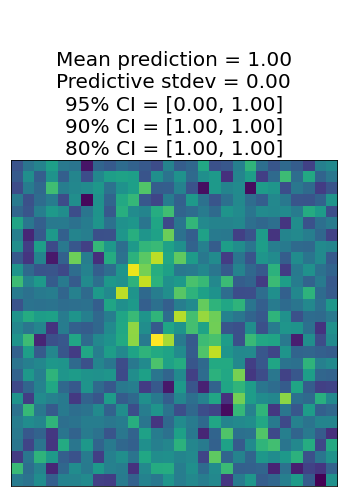

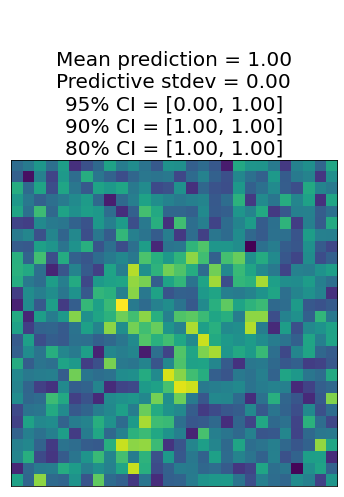

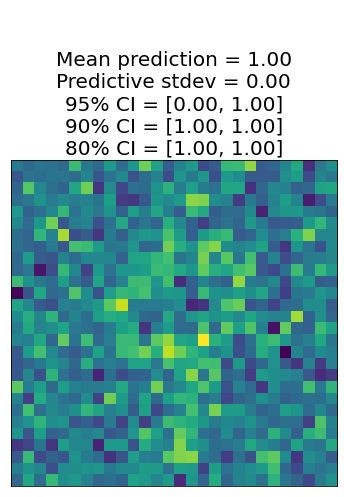

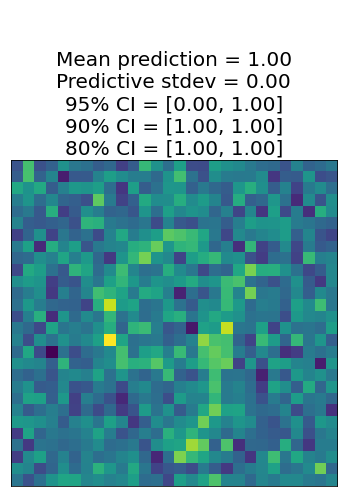

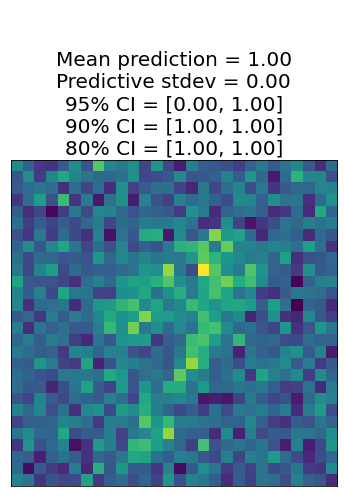

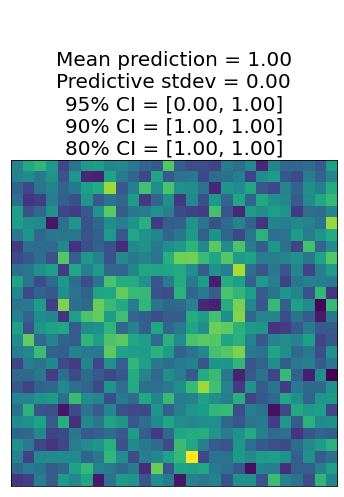

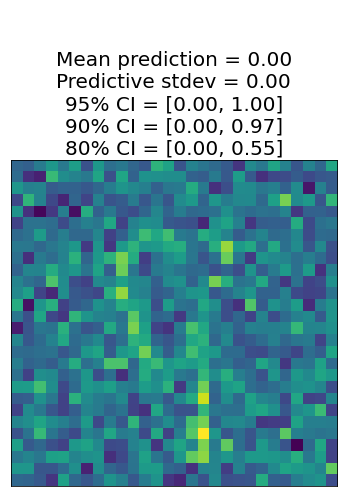

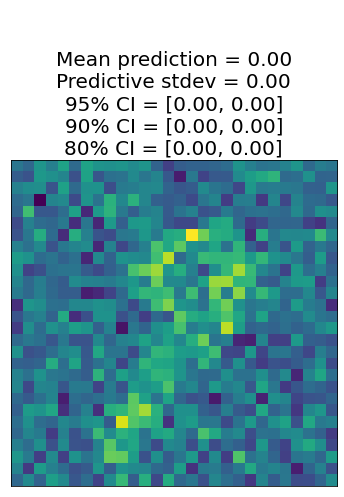

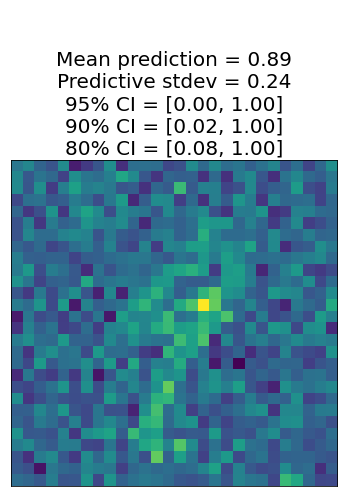

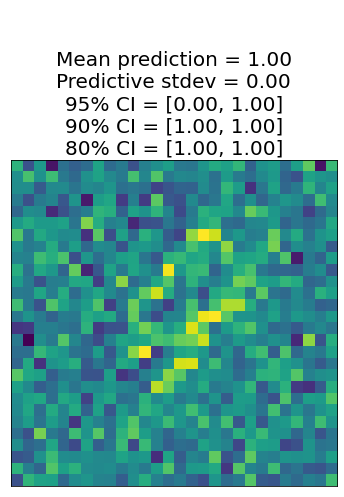

In [74]:
TOLERANCE = 1e-6

mean_predictions = get_mean_predictions(
    prediction_matrix=simple_prediction_matrix_testing,
    quantile_levels=QUANTILE_LEVELS
)
predictive_stdevs = get_predictive_stdevs(
    prediction_matrix=simple_prediction_matrix_testing,
    quantile_levels=QUANTILE_LEVELS
)

bottom_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.025) <= TOLERANCE
)[0][0]
top_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.975) <= TOLERANCE
)[0][0]

bottom_predictions_ci95 = simple_prediction_matrix_testing[:, bottom_index]
top_predictions_ci95 = simple_prediction_matrix_testing[:, top_index]

bottom_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.05) <= TOLERANCE
)[0][0]
top_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.95) <= TOLERANCE
)[0][0]

bottom_predictions_ci90 = simple_prediction_matrix_testing[:, bottom_index]
top_predictions_ci90 = simple_prediction_matrix_testing[:, top_index]

bottom_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.1) <= TOLERANCE
)[0][0]
top_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.9) <= TOLERANCE
)[0][0]

bottom_predictions_ci80 = simple_prediction_matrix_testing[:, bottom_index]
top_predictions_ci80 = simple_prediction_matrix_testing[:, top_index]

positive_target_indices = numpy.where(testing_target_values == 1)[0][:10]

for i in positive_target_indices:
    _, axes_object = pyplot.subplots(
        1, 1, figsize=(6, 6)
    )

    axes_object.imshow(testing_predictor_matrix[i, ..., 0])
    axes_object.set_xticks([])
    axes_object.set_yticks([])

    title_string = (
        '\n\nMean prediction = {0:.2f}\n'
        'Predictive stdev = {1:.2f}\n'
        '95% CI = [{2:.2f}, {3:.2f}]\n'
        '90% CI = [{4:.2f}, {5:.2f}]\n'
        '80% CI = [{6:.2f}, {7:.2f}]'
    ).format(
        mean_predictions[i], predictive_stdevs[i],
        bottom_predictions_ci95[i], top_predictions_ci95[i],
        bottom_predictions_ci90[i], top_predictions_ci90[i],
        bottom_predictions_ci80[i], top_predictions_ci80[i]
    )

    axes_object.set_title(title_string, fontsize=20)

# Objective evaluation for simple model

## Spread-skill plot

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Spread-skill reliability = 0.087')

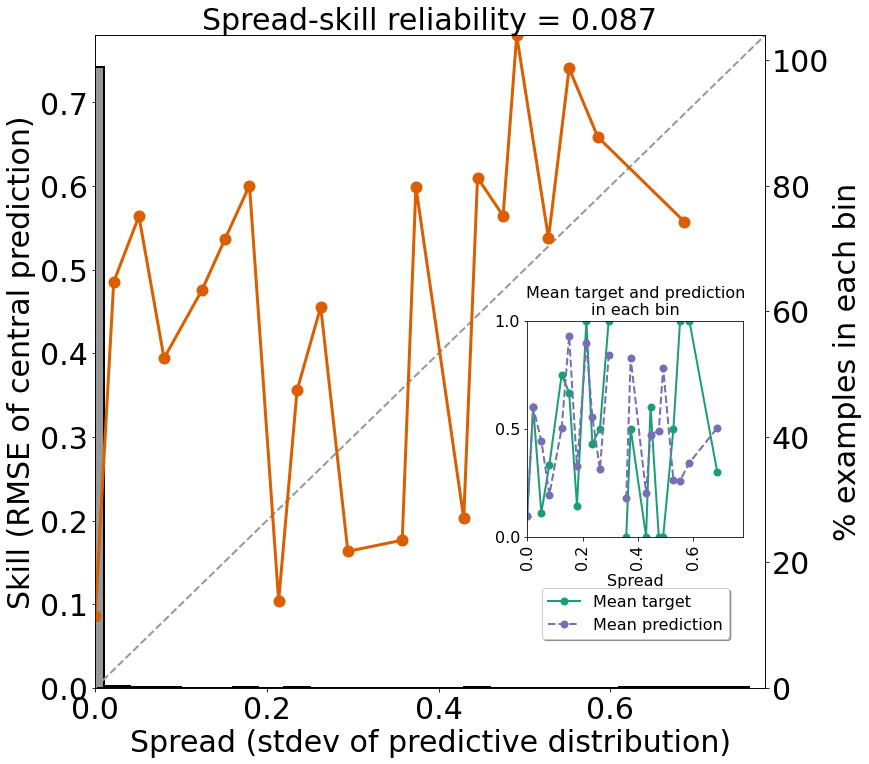

In [75]:
BIN_EDGE_PREDICTION_STDEVS = numpy.linspace(0.01, 0.61, num=21)

result_dict = get_spread_vs_skill(
    prediction_matrix=simple_prediction_matrix_testing,
    target_values=testing_target_values,
    quantile_levels=QUANTILE_LEVELS,
    bin_edge_prediction_stdevs=BIN_EDGE_PREDICTION_STDEVS
)

_, axes_object = plot_spread_vs_skill(result_dict)
title_string = 'Spread-skill reliability = {0:.2g}'.format(
    result_dict[SPREAD_SKILL_RELIABILITY_KEY]
)
axes_object.set_title(title_string)

## Discard test

Text(0.5, 1.0, 'Monotonicity fraction = 0.16')

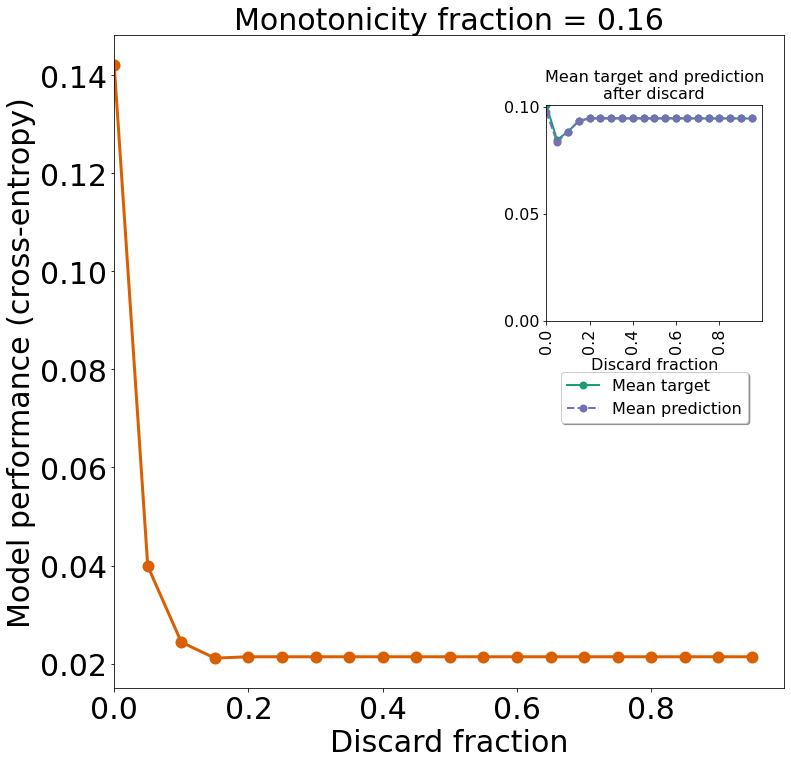

In [76]:
DISCARD_FRACTIONS = numpy.linspace(0.05, 0.95, num=19)

result_dict = run_discard_test(
    prediction_matrix=simple_prediction_matrix_testing,
    target_values=testing_target_values,
    quantile_levels=QUANTILE_LEVELS,
    discard_fractions=DISCARD_FRACTIONS
)

_, axes_object = plot_discard_test(result_dict)
title_string = 'Monotonicity fraction = {0:.2f}'.format(
    result_dict[MONOTONICITY_FRACTION_KEY]
)
axes_object.set_title(title_string)

# Train fancy model

The following cell trains the fancy NN and looks at some predictions.  Note that the fancy NN completely prevents quantile-crossing!

In [77]:
# fancy_model_object.fit(
#     training_predictor_matrix, training_target_values,
#     batch_size=128, epochs=5, verbose=1,
#     validation_data=(testing_predictor_matrix, testing_target_values)
# )

fancy_model_object.fit(
    training_predictor_matrix, training_target_values,
    batch_size=128, epochs=30, verbose=1,
    validation_data=(testing_predictor_matrix, testing_target_values)
)

fancy_prediction_matrix_testing = fancy_model_object.predict_on_batch(
    testing_predictor_matrix
)
fancy_prediction_matrix_testing = numpy.stack(
    fancy_prediction_matrix_testing, axis=1
)[..., 0]

num_quantile_levels = len(QUANTILE_LEVELS)
print('\n\n')

for k in range(num_quantile_levels):
    print((
        'Min, mean, and max prediction for quantile level {0:.2f} = '
        '{1:.4f}, {2:.4f}, {3:.4f}'
    ).format(
        QUANTILE_LEVELS[k], numpy.min(fancy_prediction_matrix_testing[:, k]),
        numpy.mean(fancy_prediction_matrix_testing[:, k]),
        numpy.max(fancy_prediction_matrix_testing[:, k])
    ))

print('\n\n')
fancy_diff_matrix_testing = numpy.diff(
    fancy_prediction_matrix_testing, axis=1
)

print((
    'Min, mean, and max difference between subsequent quantiles (negative '
    'differences mean there is quantile-crossing) = {0:.4f}, {1:.4f}, {2:.4f}'
).format(
    numpy.min(fancy_diff_matrix_testing),
    numpy.mean(fancy_diff_matrix_testing),
    numpy.max(fancy_diff_matrix_testing)
))

print((
    'Percentage of differences below zero (quantile-crossing) = {0:.2f}%'
).format(
    100 * numpy.mean(fancy_diff_matrix_testing < 0)
))

Epoch 1/30
469/469 [==============================] - 32s 69ms/step - loss: 1.3666 - output01_loss: 0.0011 - output02_loss: 0.0021 - output03_loss: 0.0025 - output04_loss: 0.0030 - output05_loss: 0.0037 - output06_loss: 0.0042 - output07_loss: 0.0049 - output08_loss: 0.0054 - output09_loss: 0.0059 - output10_loss: 0.0065 - output11_loss: 0.0069 - output12_loss: 0.0074 - output13_loss: 0.0077 - output14_loss: 0.0081 - output15_loss: 0.0084 - output16_loss: 0.0087 - output17_loss: 0.0090 - output18_loss: 0.0093 - output19_loss: 0.0096 - output20_loss: 0.0100 - output21_loss: 0.0104 - output22_loss: 0.0107 - output23_loss: 0.0111 - output24_loss: 0.0113 - output25_loss: 0.0116 - output26_loss: 0.0118 - output27_loss: 0.0120 - output28_loss: 0.0123 - output29_loss: 0.0125 - output30_loss: 0.0128 - output31_loss: 0.0130 - output32_loss: 0.0133 - output33_loss: 0.0135 - output34_loss: 0.0138 - output35_loss: 0.0140 - output36_loss: 0.0142 - output37_loss: 0.0144 - output38_loss: 0.0146 - out

# Case studies for fancy model

Now we look at 10 case studies for the fancy model.

Again, note that the model has more uncertainty for weird-looking nines, manifesting in a larger predictive stdev and wider confidence intervals.

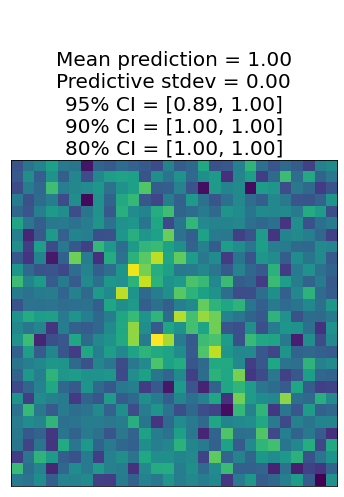

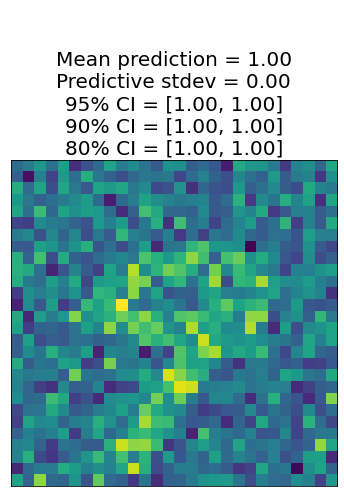

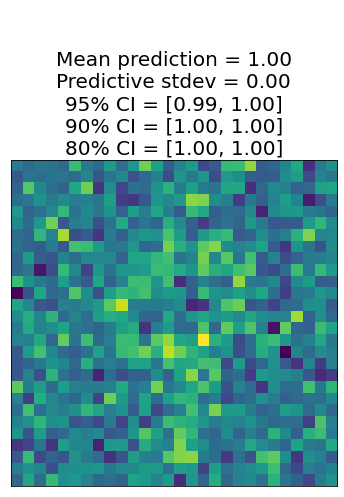

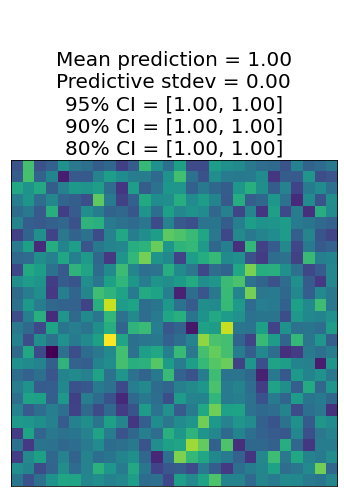

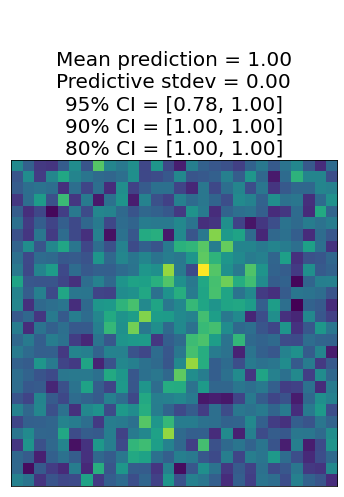

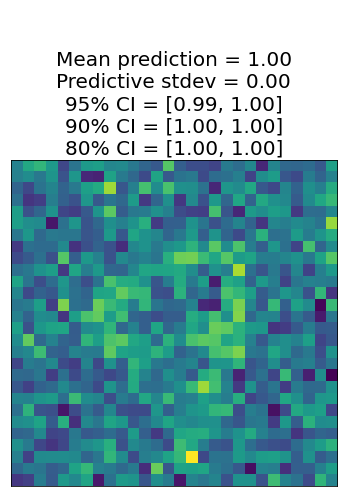

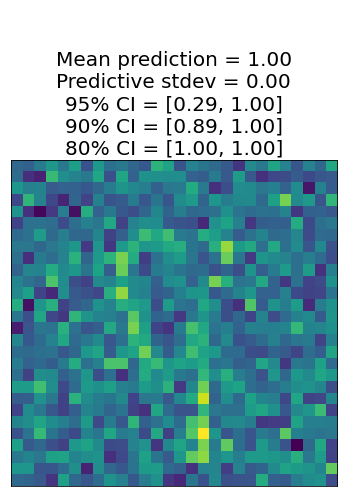

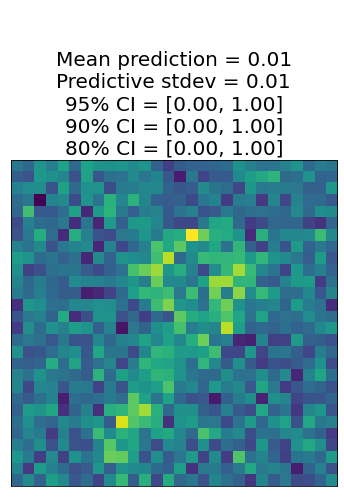

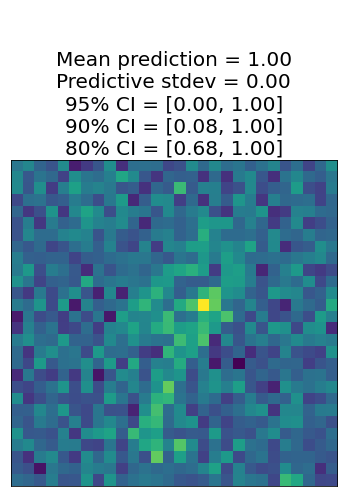

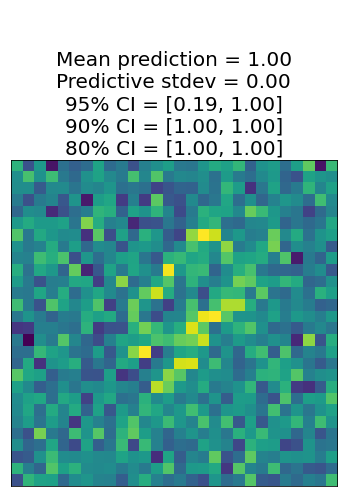

In [78]:
TOLERANCE = 1e-6

mean_predictions = get_mean_predictions(
    prediction_matrix=fancy_prediction_matrix_testing,
    quantile_levels=QUANTILE_LEVELS
)
predictive_stdevs = get_predictive_stdevs(
    prediction_matrix=fancy_prediction_matrix_testing,
    quantile_levels=QUANTILE_LEVELS
)

bottom_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.025) <= TOLERANCE
)[0][0]
top_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.975) <= TOLERANCE
)[0][0]

bottom_predictions_ci95 = fancy_prediction_matrix_testing[:, bottom_index]
top_predictions_ci95 = fancy_prediction_matrix_testing[:, top_index]

bottom_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.05) <= TOLERANCE
)[0][0]
top_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.95) <= TOLERANCE
)[0][0]

bottom_predictions_ci90 = fancy_prediction_matrix_testing[:, bottom_index]
top_predictions_ci90 = fancy_prediction_matrix_testing[:, top_index]

bottom_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.1) <= TOLERANCE
)[0][0]
top_index = numpy.where(
    numpy.absolute(QUANTILE_LEVELS - 0.9) <= TOLERANCE
)[0][0]

bottom_predictions_ci80 = fancy_prediction_matrix_testing[:, bottom_index]
top_predictions_ci80 = fancy_prediction_matrix_testing[:, top_index]

positive_target_indices = numpy.where(testing_target_values == 1)[0][:10]

for i in positive_target_indices:
    _, axes_object = pyplot.subplots(
        1, 1, figsize=(6, 6)
    )

    axes_object.imshow(testing_predictor_matrix[i, ..., 0])
    axes_object.set_xticks([])
    axes_object.set_yticks([])

    title_string = (
        '\n\nMean prediction = {0:.2f}\n'
        'Predictive stdev = {1:.2f}\n'
        '95% CI = [{2:.2f}, {3:.2f}]\n'
        '90% CI = [{4:.2f}, {5:.2f}]\n'
        '80% CI = [{6:.2f}, {7:.2f}]'
    ).format(
        mean_predictions[i], predictive_stdevs[i],
        bottom_predictions_ci95[i], top_predictions_ci95[i],
        bottom_predictions_ci90[i], top_predictions_ci90[i],
        bottom_predictions_ci80[i], top_predictions_ci80[i]
    )

    axes_object.set_title(title_string, fontsize=20)

# Objective evaluation for fancy model

## Spread-skill plot

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Spread-skill reliability = 0.094')

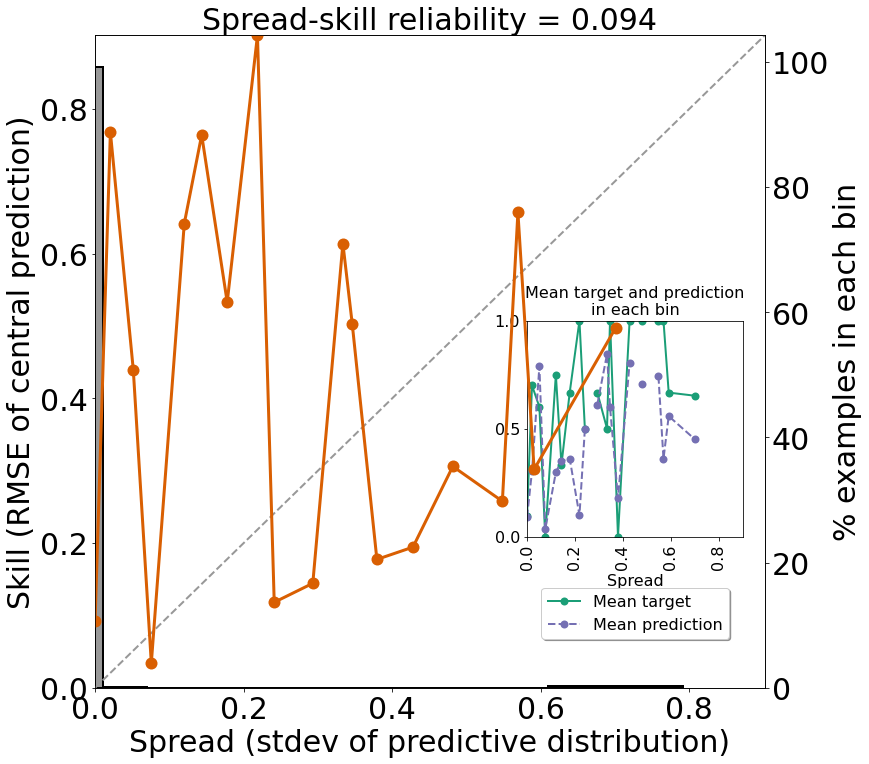

In [79]:
BIN_EDGE_PREDICTION_STDEVS = numpy.linspace(0.01, 0.61, num=21)
DISCARD_FRACTIONS = numpy.linspace(0.05, 0.95, num=19)

result_dict = get_spread_vs_skill(
    prediction_matrix=fancy_prediction_matrix_testing,
    target_values=testing_target_values,
    quantile_levels=QUANTILE_LEVELS,
    bin_edge_prediction_stdevs=BIN_EDGE_PREDICTION_STDEVS
)

_, axes_object = plot_spread_vs_skill(result_dict)
title_string = 'Spread-skill reliability = {0:.2g}'.format(
    result_dict[SPREAD_SKILL_RELIABILITY_KEY]
)
axes_object.set_title(title_string)

## Discard test

Text(0.5, 1.0, 'Monotonicity fraction = 0.05')

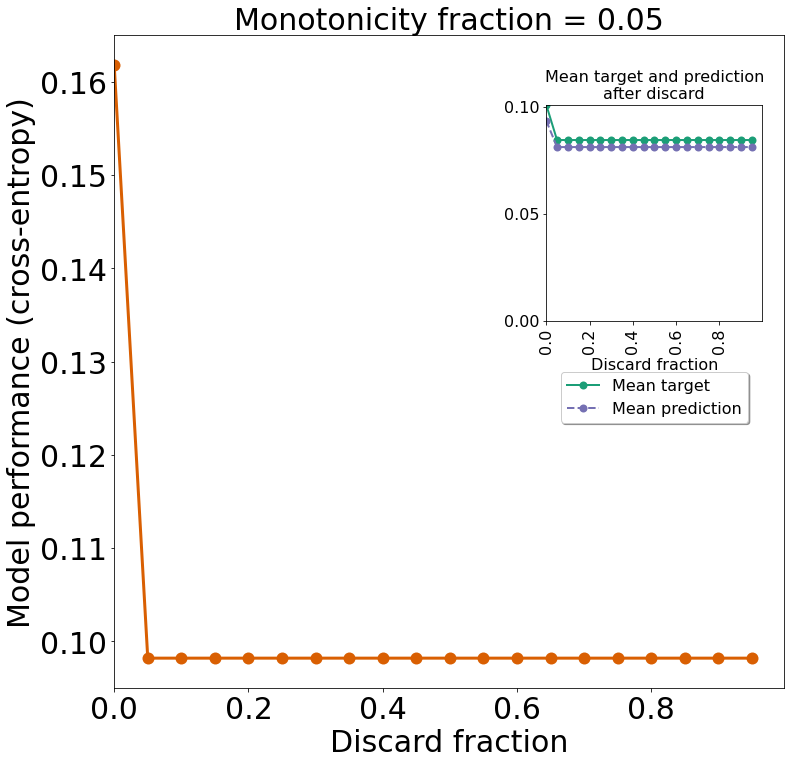

In [80]:
result_dict = run_discard_test(
    prediction_matrix=fancy_prediction_matrix_testing,
    target_values=testing_target_values,
    quantile_levels=QUANTILE_LEVELS,
    discard_fractions=DISCARD_FRACTIONS
)

_, axes_object = plot_discard_test(result_dict)
title_string = 'Monotonicity fraction = {0:.2f}'.format(
    result_dict[MONOTONICITY_FRACTION_KEY]
)
axes_object.set_title(title_string)